# Gaussian Random Walk with an expanding window

This notebooks implements the Gaussian Random Walk in (Py)Stan and shows how to run it to predict every single date in the time series

In [2]:
# nest_asyncio is needed for running pystan in a notebook
import nest_asyncio
nest_asyncio.apply()

import stan
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import time

In [4]:
# Constants
reference_data_path = "~/Downloads/train.csv"
random_seed = 42
train_date_end = 62
days_forward = 5
date_start = datetime(2018, 12, 1)
date_end = datetime(2019, 5, 1)
avg_installs_per_day = 200
sample_size = (date_end - date_start).days * avg_installs_per_day

## Load the data from Kaggle 
- we are going to use just a small sample of the original data, restricting it both in span of days and in the number of users
- the reason to reduce the number of days is merely to decrease total computation time
- the reason to reduce the number of users is to make the average LTV per day more noisy, thus being more similar to the more challenging scenarios seen in the industry

In [6]:
# load data from https://www.kaggle.com/datasets/baetulo/lifetime-value?select=train.csv
data = pd.read_csv(reference_data_path)
data.head(10)

,product_type,user_id,join_date,hidden,product,STV,target,credit_card_level,is_lp,aff_type,is_cancelled,country_segment
0,type_ex,7.0,2018-12-01 00:01:45,0,product_1,8.25,8.25,standard,0,PPL,NaN,US
1,type_ex,20.0,2018-12-01 00:06:05,0,product_2,8.25,8.25,standard,0,PPL,NaN,US
2,type_ex,22.0,2018-12-01 00:06:23,0,product_3,8.25,8.25,prepaid,0,PPL,NaN,US
3,type_ex,26.0,2018-12-01 00:07:12,0,product_2,8.25,8.25,standard,0,PPL,NaN,US
4,type_ex,59.0,2018-12-01 00:15:21,0,product_2,8.25,8.25,standard,0,PPL,NaN,Other Countries
5,type_ex,63.0,2018-12-01 00:15:28,0,product_1,8.25,8.25,standard,0,PPS,NaN,US
6,type_ex,70.0,2018-12-01 00:16:32,0,product_4,8.25,8.25,standard,0,PPL,NaN,US
7,type_ex,82.0,2018-12-01 00:21:14,0,product_1,8.25,8.25,standard,0,PPS,NaN,US
8,type_ex,87.0,2018-12-01 00:22:40,0,product_2,8.25,8.25,standard,1,PPS,NaN,Other Countries
9,type_ex,102.0,2018-12-01 00:26:55,0,product_2,8.25,8.25,standard,0,PPL,NaN,US


In [7]:
# cast join_date to int (days since date_start) to pass it to stan
data['join_date'] = pd.to_datetime(data['join_date'])
data= data[(data['join_date'] >= date_start) & (data['join_date'] <= date_end)]
data['join_date'] = (data['join_date'] - date_start).dt.days.values
data = data.sample(10000, random_state=random_seed)

In [9]:
time_series_model = """
data {
  int<lower=0> N;
  int<lower=0> n_dates;
  int date[N];
  real observation[N];
}
parameters {
    vector[n_dates] mu; //The random-walking signal
    real<lower=0.0001> sampling_stddev; // the standard deviation of the user-level LTV
    real<lower=0.0001> random_walk_stddev; // Standard deviation of random walk
}
model {
    sampling_stddev ~ cauchy(0, 2); // Define the prior for the user-level LTV
    random_walk_stddev ~ cauchy(0, 2); // Define the prior for the random walk stddev
    mu[1] ~ normal(6, 3); // 
    mu[2:n_dates] ~ normal(mu[1:(n_dates - 1)], random_walk_stddev); // Vectorized

    observation ~ normal(mu[date], sampling_stddev); // Vectorized
}
"""

In [10]:
def fit(model, stan_format_data):
    # train the model
    start_time = time.time()
    posterior = stan.build(model, data=stan_format_data)
    fit = posterior.sample(num_chains=3, num_samples=1000)
    print(f"Training the model took {time.time() - start_time} seconds")
    
    return fit.to_frame()

def predict(model_data, days_in_future: int):
    columns_ = model_data.reset_index().columns
    columns_ = [x for x in columns_ if 'mu' in x]
    rw_std = model_data['random_walk_stddev']
    last_avg = model_data[columns_[-1]]
    return np.random.normal(last_avg, days_in_future * rw_std)

def fit_predict(model, stan_format_data, days_in_future):
    model_data = fit(model, stan_format_data)
    predictions = predict(model_data, days_in_future)
    return predictions

In [11]:
max_date = data['join_date'].max()

training_days_selection = [i for i in range(train_date_end, max_date - days_forward, 1)]
all_predictions = None

for training_days in training_days_selection:
    
    sub_data = data[data['join_date'] <= training_days]
    # get the data for STAN
    stan_format_data = {}
    stan_format_data['N'] = int(sub_data.shape[0])
    stan_format_data['n_dates'] = len(sub_data['join_date'].unique())
    stan_format_data['date'] = list(sub_data['join_date'].values + 1) # +1 because STAN start 1
    stan_format_data['observation'] = list(sub_data['target'].values)
    
    predictions = fit_predict(time_series_model, stan_format_data, days_forward)
    predictions = pd.DataFrame(predictions)
    
    predictions['join_date'] = training_days + days_forward
    if all_predictions is None:
        all_predictions = predictions        
    else:
        all_predictions = pd.concat([all_predictions, predictions], axis=0)
        
    all_predictions.to_csv('~/Documents/simulations_predictions.csv')


Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/_1/c79n_fvs2bx1dwv8qf9wj04h0000gn/T/httpstan_h36kbvgn/model_msufuh7w.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/_1/c79n_fvs2bx1dwv8qf9wj04h0000gn/T/httpstan_h36kbvgn/model_msufuh7w.stan', line 6, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/6000)
Sampling:  10% (600/6000

Training the model took 9.155429124832153 seconds


Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  40% (2400/6000)
Sampling:  58% (3500/6000)
Sampling:  82% (4900/6000)
Sampling:  88% (5300/6000)
Sampling:  90% (5400/6000)
Sampling:  92% (5500/6000)
Sampling:  93% (5600/6000)
Sampling:  95% (5700/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.0001 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1 seconds.
  Adjust your exp

Training the model took 14.381925106048584 seconds


Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:  10% (600/6000)
Sampling:  13% (800/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  23% (1400/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  40% (2400/6000)
Sampling:  60% (3600/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000109 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000167 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.67 seconds.
  Ad

Training the model took 8.80799388885498 seconds


AttributeError: 'NoneType' object has no attribute 'to_frame'

In [32]:

all_predictions = pd.read_csv('./results/PyData_Amsterdam_2023_ltv_forecasting.csv')
ci_df = all_predictions.groupby('join_date')['0'].quantile([0.05, 0.95]).unstack(level=1)

In [33]:
summarized_predictions = all_predictions.groupby(['join_date'])['0'].mean().reset_index()
summarized_data = data.groupby(['join_date'])['target'].mean().reset_index()
summarized_data['type'] = 'observed'

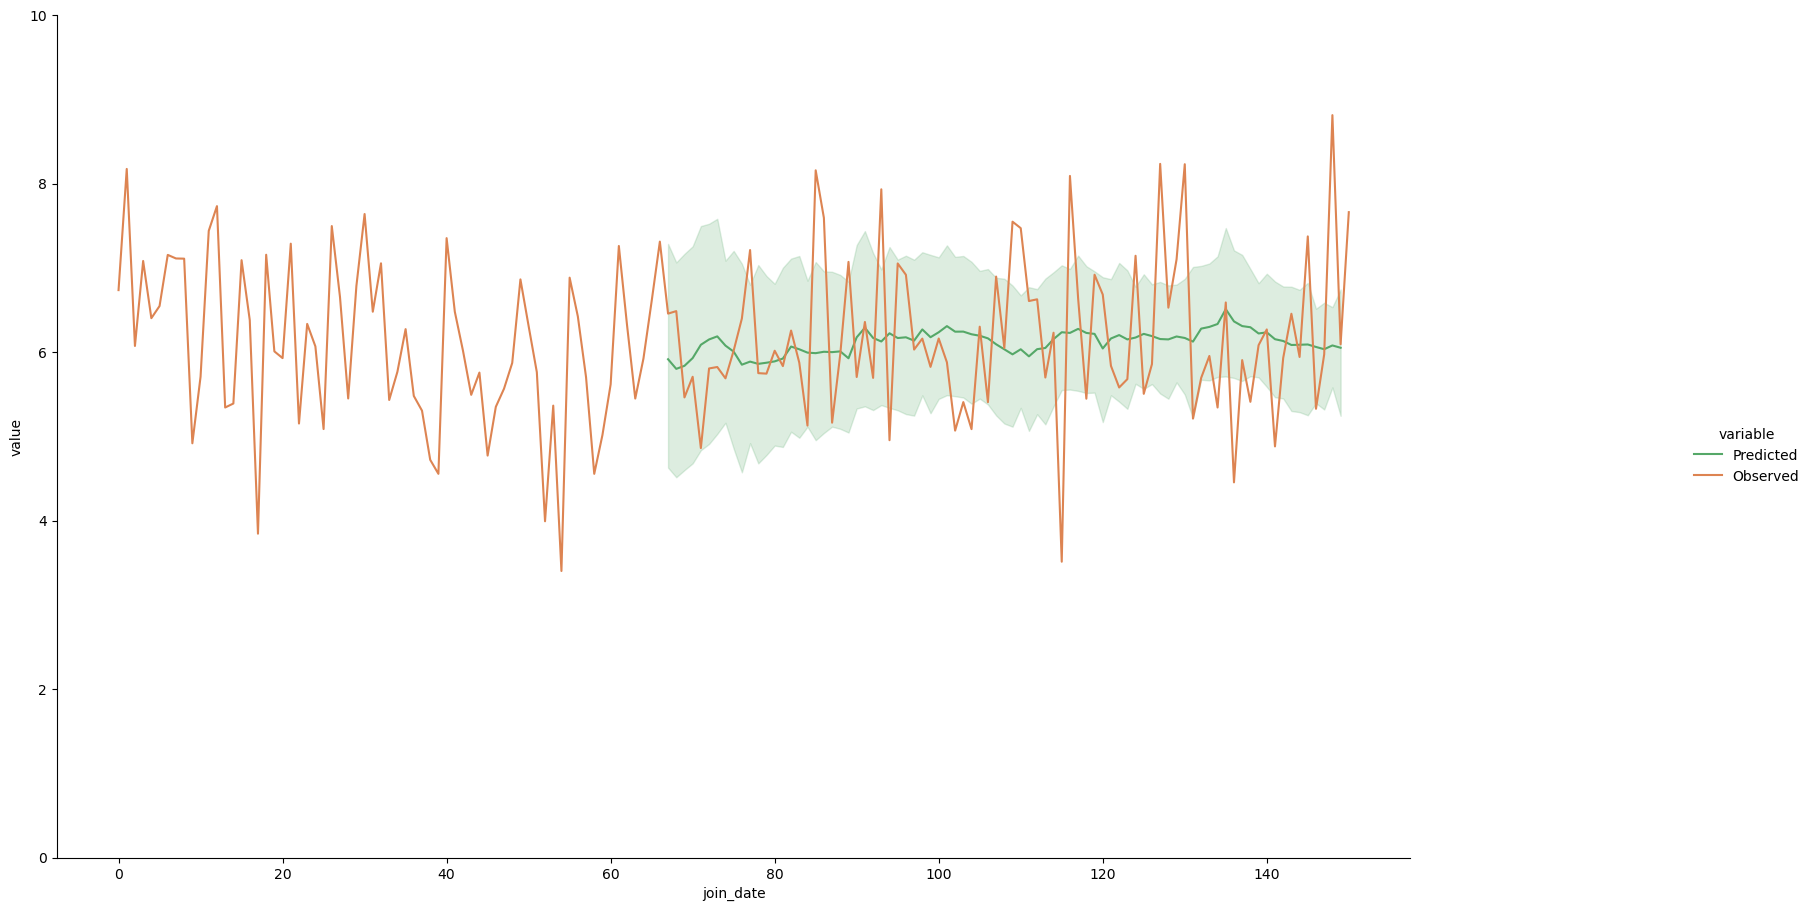

In [41]:
# create a data to plot the estimated value, the observed value, and the 'true' value
plot_data = pd.merge(summarized_data, summarized_predictions, on='join_date', how='left')
plot_data = pd.merge(
    summarized_data, 
    summarized_predictions, 
    on='join_date', how='left')
plot_data = plot_data[['join_date', '0', 'target']]
plot_data = plot_data.rename(columns={'0': 'Predicted', 'target': 'Observed'})
plot_data = pd.melt(plot_data, id_vars='join_date', value_vars=['Predicted', 'Observed'])

palette = sns.color_palette("deep")
palette = [palette[2], palette[1]]

g = sns.relplot(
    plot_data, 
    x='join_date',
    y='value', 
    hue='variable', 
    palette=palette, 
    kind='line', 
    facet_kws={'ylim': [0, 10]}
)
g.figure.set_size_inches(20, 10)

for ax in g.axes.flat:
    ax.fill_between(ci_df.index, ci_df[0.05], ci_df[0.95], alpha=0.2, color = palette[0])